# Fine scale variance of surface salinity


__author__ : Aurélie Albert & Julien Le Sommer (MEOM)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 12 July 2017

__purpose__ : Metric for the intensity of the fine scale of surface temperature in NATL60-CJM165 simulation

__detailed description__ : 
Fine scale variance is defined at a given time and space by :

$$V(X) = (X - \langle X \rangle)^{2}$$

with $\langle . \rangle$ the low pass filtering operator. An average in time and space of the variance is then defined as : 

$$\overline{(X(t)-\langle X \rangle)^{2}}^{t,x,y}$$

with $\overline{X}^{t,x,y}$ a boxcar averager.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of surface salinity for the month March and September 2013
  * step 1. : Snapshots of sea surface salinity (15 March - 15 October 2013 )
  * step 2. : Filtering of input data is performed with Lanczos2DHighPassFilter.py on command line so that the filtered signal is kept in netcdf files equivalent to input data
  * step 3. : Variance of the high-pass filtered surface salinity and boxcar averaging in 1°x1°x1 month boxes
  * step 4. : Maps of fine scale variance of surface salinity in March and October 2013
  
__external libraries needed to run this script__ : 

 * GriddedData : https://github.com/lesommer/codes/blob/master/GriddedData.py
 * WavenumberSpectrum : https://github.com/lesommer/codes/blob/master/WavenumberSpectrum.py
 * oocgcm filtering module : https://github.com/lesommer/oocgcm
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
netCDF4 1.2.4
Mon Aug 28 11:46:29 2017 CEST

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [3]:
## imports

import numpy as np
import xarray as xr
import GriddedData
import time

In [4]:
#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

## 1. Snapshots of surface salinity (15 March - 15 October 2013 )

In [7]:
## Dataset

dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/"
dirin="/media/extra/DATA/NATL60/NATL60-I/"

files03="NATL60-CJM165_y2013m03d*.1d_sosaline.nc"
files09="NATL60-CJM165_y2013m09d*.1d_sosaline.nc"

tfiles03=dir+files03
tfiles09=dir+files09

!ls $tfiles03
!ls $tfiles09

/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d01.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d02.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d03.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d04.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d05.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d06.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d07.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d08.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d09.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d10.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/surf/NATL60-CJM165_y2013m03d11.1d_sosaline.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/su

In [6]:
gridfile=dirin+"NATL60_grid.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc


In [7]:
def load_and_plot(tfile,title,var,vmin,vmax,cmap):
    '''  load one daily file and plot the surface field
        
    '''
    curls = xr.open_dataset(tfile)
    curl15=curls[var][0]
    navlat= curls['nav_lat']
    navlon= curls['nav_lon']
    cont=np.isnan(curl15)
    
    plt.figure(figsize=(15,11))
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    pcolor = ax.pcolormesh(navlon,navlat,
      ma.masked_invalid(curl15),cmap=cmap,vmin=vmin,vmax=vmax,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.title(title,fontsize=25)
    

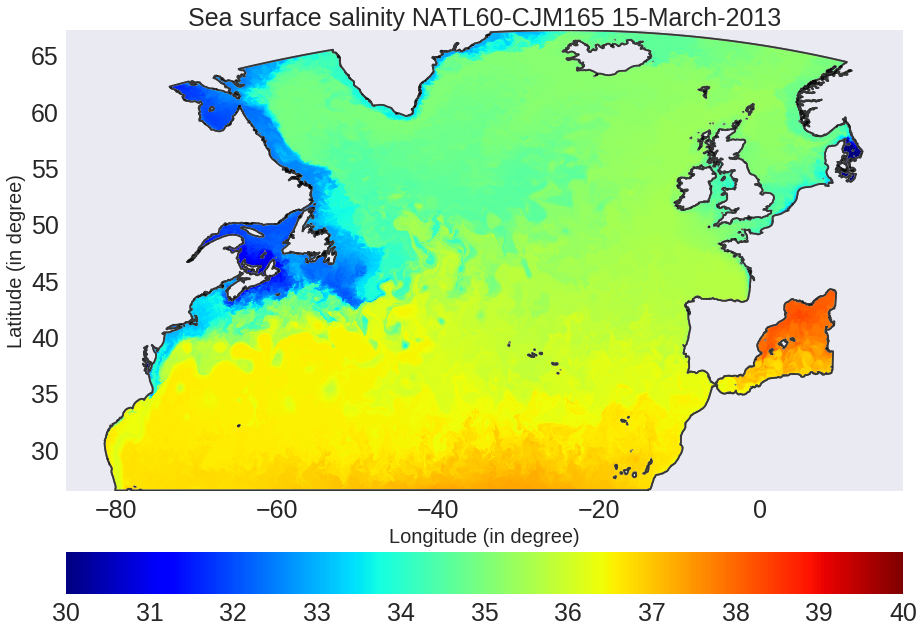

In [8]:
files0315="NATL60-CJM165_y2013m03d15.1d_sosaline.nc"
tfiles0315=dir+files0315

var='sosaline'
vmin=30
vmax=40
cmap='jet'
load_and_plot(tfiles0315,'Sea surface salinity NATL60-CJM165 15-March-2013',var,vmin,vmax,cmap)

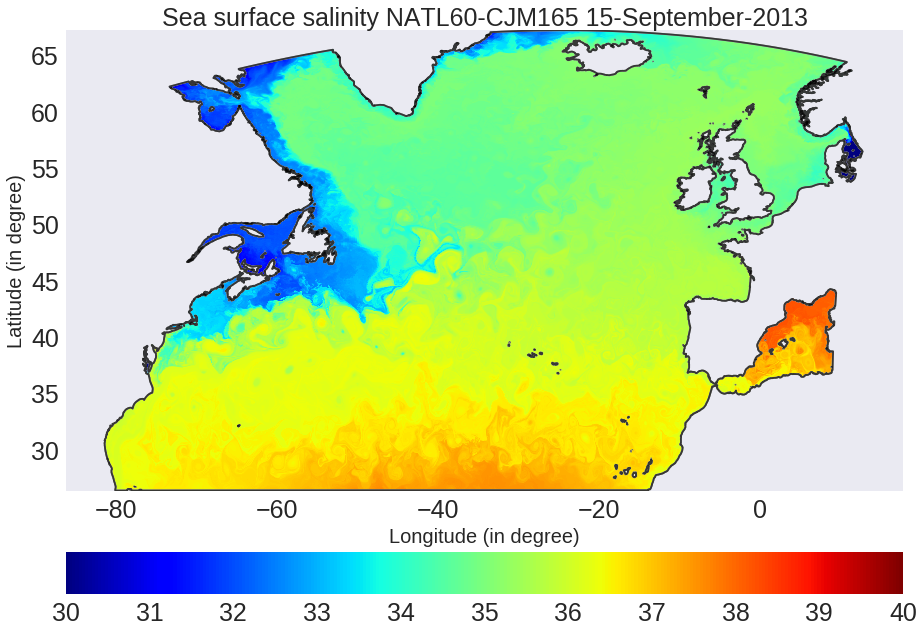

In [9]:
files0915="NATL60-CJM165_y2013m09d15.1d_sosaline.nc"
tfiles0915=dir+files0915

var='sosaline'
vmin=30
vmax=40
cmap='jet'
load_and_plot(tfiles0915,'Sea surface salinity NATL60-CJM165 15-September-2013',var,vmin,vmax,cmap)

## 2. Filtering of input data

We used Lanczos2DHighPassFilter.py script to filter vorticity files with the options n=80 (size of Lanczos window) and f=0.0125 (cut-off frequency) : 

```
python Lanczos2DHighPassFilter.py -v 'sosstsst' -s  /media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d*.1d_sosstsst.nc 80 0.0125
```

These parameters have been chosen for NATL60 outputs, they have to be tuned regarding the resolution of the data.
A spectra of the resulting filtered signal compared to the total signal confirm that the filter has the wanted effective cut-off frequency and a clean energy separation.

In [10]:
# compute the spectra over 10°x10° box for one example file

test_file="NATL60-CJM165_y2013m03d01.1d_sosaline.nc"
tf_test_file="NATL60-CJM165_y2013m03d01.1d_sosaline_filt-n80-f0.0125.nc"
test=dir+test_file
tf_test=dir+tf_test_file


ds = xr.open_dataset(test)
hpds = xr.open_dataset(tf_test)
grid=xr.open_dataset(gridfile)

navlon = np.array(grid["nav_lon"]).squeeze()
navlat = np.array(grid["nav_lat"]).squeeze()

curl = ds['sosaline']
hpcurl = hpds['sosaline_filt']


zfull = curl[0,600:1200,1800:2400].values # si pas .values plot ok mais ne peut pas calculer le spectre
zfull[np.where(np.isnan(zfull))]=0. # 0. are missing values so they are converted to nan

zhp = hpcurl[0,600:1200,1800:2400].values
zhp[np.where(np.isnan(zhp))]=0. # 0. are missing values so they are converted to nan

zlp = zfull - zhp

zlon = navlon[600:1200,1800:2400]
zlat = navlat[600:1200,1800:2400]

#- compute the wavenumber spectrum
interp = 'basemap'

def compute_spectrum(var):
    data = var.squeeze()
    x_reg,y_reg,data_reg = ws.interpolate(data,zlon,zlat,interp=interp)
    pspec,kstep = ws.get_spectrum_1d(data_reg,x_reg,y_reg)
    return pspec, kstep

%time spectre_full = compute_spectrum(zfull)
%time spectre_hp   = compute_spectrum(zhp)
%time spectre_lp   = compute_spectrum(zlp)

#- plot the mean spectrum 
rad2cyc = 1.E3 / np.pi / 2. 

def nice_spectrum(spectre_full,spectre_hp,spectre_lp):
    fig, axarr = plt.subplots(1,1)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    #
    pspec,kstep = spectre_full
    pspec_lp,kstep_lp = spectre_lp
    pspec_hp,kstep_hp = spectre_hp
    skstep = kstep * rad2cyc
    y_min = 10 ** np.floor(np.log10(pspec.min())-1)
    y_max = 10 ** np.ceil( np.log10(pspec.max())+1)
    axarr.plot(skstep[1:], pspec[1:],'k-', lw=3, label='Full SSS')
    axarr.plot(skstep[1:], pspec_lp[1:],'r-', lw=3, label='Low passed SSS f=0.0125 n=80')
    axarr.plot(skstep[1:], pspec_hp[1:],'b-', lw=3, label='Full - Low passed  f=0.0125 n=80')
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.set_xbound(1e-5*rad2cyc, 1e-2*rad2cyc)
    axarr.set_ybound(y_min, y_max)
    axarr.set_title('',fontsize=20)
    axarr.grid(True,which='both',ls='-')
    axarr.axis('tight')
    axarr.legend(loc="lower left", fontsize=25)
    axarr.tick_params(labelsize=25)





CPU times: user 1.62 s, sys: 8 ms, total: 1.63 s
Wall time: 1.63 s
CPU times: user 1.5 s, sys: 4 ms, total: 1.51 s
Wall time: 1.5 s
CPU times: user 1.5 s, sys: 4 ms, total: 1.51 s
Wall time: 1.5 s


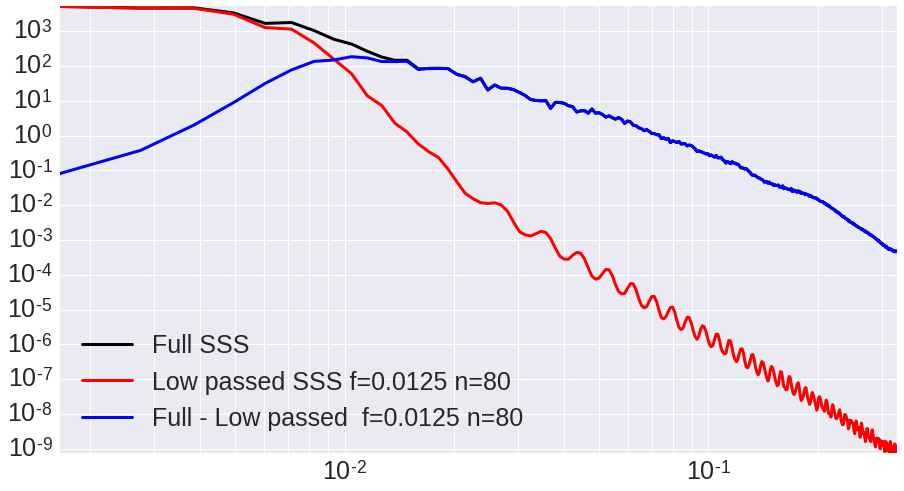

In [11]:
nice_spectrum(spectre_full,spectre_hp,spectre_lp)

In [10]:
filt_files03="NATL60-CJM165_y2013m03d*.1d_sosaline_filt-n80-f0.0125.nc"
filt_files09="NATL60-CJM165_y2013m09d*.1d_sosaline_filt-n80-f0.0125.nc"

dir='/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/'
tf_files03=dir+filt_files03
tf_files09=dir+filt_files09

!ls $tf_files03
!ls $tf_files09

/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d01.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d02.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d03.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d04.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d05.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d06.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d07.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d08.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y2013m03d09.1d_sosaline_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/filt/NATL60-CJM165_y201

## 3. Variance of the high-pass filtered sst and boxcar averaging in 1°x1°x1 month boxes

In [11]:
def fine_scale_variance(files):
    ''' from a list of files containing one month of data compute variance and average in 1°x1°x1 month boxes
    '''
    hpcurl = xr.open_mfdataset(files,concat_dim='time_counter',decode_times=False)['sosaline_filt']
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    return loncrsm,latcrsm,hpcurl2mcm,hpcurl2m



In [12]:
loncrsm03, latcrsm03, boxvarcurl03, hpvarm03 = fine_scale_variance(tf_files03)

NameError: global name 'navlat' is not defined

In [15]:
loncrsm09, latcrsm09, boxvarcurl09, hpvarm09  = fine_scale_variance(tf_files09)

## 4. Maps of fine scale variance of sst in March and October 2013

In [18]:
def plot_fine_scale_variance(var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    fig = plt.figure(figsize=(15,11))
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales sss variance in '+month,fontsize=25)
    plt.savefig('fine_scale_variance_sss_NATL60-CJM165_'+month+'.png')
  

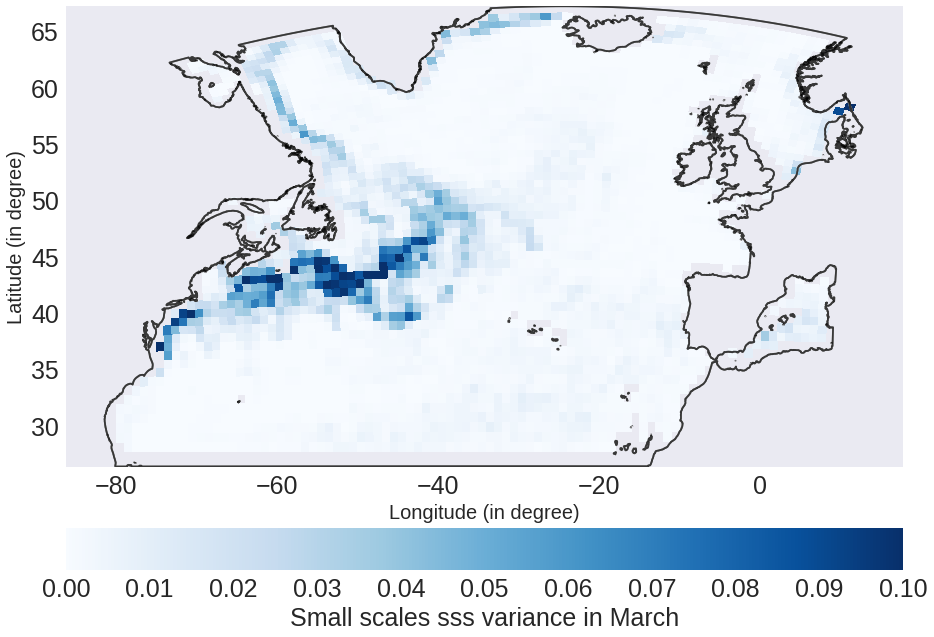

In [19]:
plot_fine_scale_variance(boxvarcurl03,loncrsm03, latcrsm03,navlon,navlat,hpvarm03,'March')

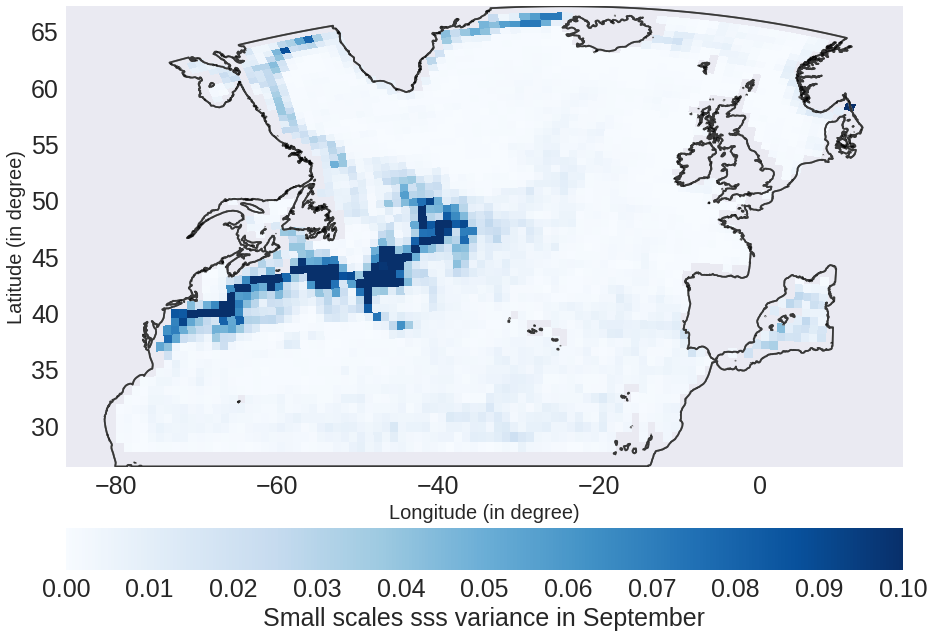

In [20]:
plot_fine_scale_variance(boxvarcurl09,loncrsm09, latcrsm09,navlon,navlat,hpvarm09,'September')